In [4]:
import pickle
import sys
import itertools

sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/")
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/src/")


from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models import BetaVAEgp, BetaVAEgpCondInd
from pythae.models import (
    BetaVAEgpCondIndConfig,
)
from pythae.models.beta_vae_gp.encoder_decoder import (
    Indep_MLP_Decoder,
    Guidance_Classifier,
    LSTM_Encoder,
    LSTM_Retrodiction_Encoder,
    LSTM_Retrodiction_Decoder,
)

from pythae.ssc.utils import (
    load_cv,
    get_classifier_config,
    remove_short_samples,
)

from pythae.models.beta_vae_gp.classifier_config import (
    EncoderDecoderConfig,
    PriorLatentConfig,
    DecoderConfig,
)
from pythae.models.beta_vae_gp.prior_latent import PriorLatent

import numpy as np
import torch
import random

from pythae.ssc.plots import plot_losses
import pandas as pd


In [5]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "/home/cctrotte/krauthammer/eustar_clean/fake_data/processed/"
name = "_ml4h"

with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, name=name)
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
weights_x0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "x"]
weights_y0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "y"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

input_size = sum(splits_x0)

static_size = sum(splits_s0)
latent_dim = 22
model_name = "VAE"
best_params = best = {
    "samp_true_fixed_var_true": (0.05, 100, 1, [100, 100], [100], [100], [40]),
    "samp_true_fixed_var_false": (0.05, 100, 3, [100, 100], [100, 100], [20], [40]),
    "samp_false_fixed_var_true": (0.05, 100, 1, [100, 100], [100], [100], [40]),
    "samp_false_fixed_var_false": (0.1, 100, 1, [100, 100], [100], [100], [40]),
}
params = {
    "dropout": 0.1,
    "lstm_hidden_size": 100,
    "num_lstm_layers": 1,
    "hidden_dims_enc": [100, 100],
    "hidden_dims_emb_dec": [100],
    "hidden_dims_log_var_dec": [100],
    "classif_layers": [40],
}

predict = True
sample_ = True
fixed_variance = False
retrodiction = False
# to create classifier configs. Specify each classifier name, variables to predict in y, z dimensions to use and architecture of the classifier
classifier_config = {
    "lung_inv": {
        "y_names": ["LUNG_ILD_involvement_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "lung_stage": {
        "y_names": ["LUNG_ILD_stage_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_inv": {
        "y_names": ["HEART_involvement_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_stage": {
        "y_names": ["HEART_stage_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_inv": {
        "y_names": ["ARTHRITIS_involvement_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_stage": {
        "y_names": ["ARTHRITIS_stage_or"],
        "z_dims": np.arange(0, 22),
        "layers": params["classif_layers"],
        "type": "static",
    },
}
# weights for the different losses
beta = 0.01
# overall weight factor for the classifiers
w_class = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}

w_recon = 1

# weights for the different losses

# overall weight factor for the classifiers
w_class_pred = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}

w_recon_pred = 1

if w_recon == 0:
    print(f"reconstruction loss weight is 0")
classifier_configs = get_classifier_config(names_y0, splits_y0, classifier_config)

encoder_config = EncoderDecoderConfig.from_dict(
    {
        "input_dim": input_size + static_size,
        "output_dim": latent_dim,
        "latent_dim": latent_dim,
        "hidden_dims": params["hidden_dims_enc"],
        "cond_dim_time_input": 1,
        "lstm_": True,
        "lstm_hidden_size": params["lstm_hidden_size"],
        "num_lstm_layers": params["num_lstm_layers"],
        "device": device,
        "dropout": params["dropout"],
        "predict": predict,
    }
)
decoder_config = DecoderConfig.from_dict(
    {
        "latent_dim": latent_dim,
        "output_dim": input_size,
        "fixed_variance": fixed_variance,
        "hidden_dims": [],
        "hidden_dims_emb": params["hidden_dims_emb_dec"],
        "hidden_dims_log_var": params["hidden_dims_log_var_dec"],
        "cond_dim_time_latent": 1,
        "cond_dim_static_latent": static_size,
        "lstm_": False,
        "dropout": params["dropout"],
        "device": device,
    }
)

prior_config = PriorLatentConfig.from_dict(
    {
        "input_dim": 1 + static_size,
        "latent_dim": latent_dim,
        "hidden_dims": [50],
        "device": device,
        "dropout": params["dropout"],
    }
)

to_reconstruct_x = [(name, index, True) for index, name in enumerate(names_x0)]

to_reconstruct_y = [(name, index, True) for index, name in enumerate(names_y0)]
model_config = BetaVAEgpCondIndConfig(
    input_dim=(input_size,),
    sample=sample_,
    latent_dim=latent_dim,
    w_class=w_class,
    w_recon=w_recon,
    beta=beta,
    w_class_pred=w_class_pred,
    w_recon_pred=w_recon_pred,
    missing_loss=True,
    latent_prior_noise_var=1,
    classifier_config=classifier_configs,
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    prior_config=prior_config,
    splits_x0=splits_x0,
    kinds_x0=kinds_x0,
    splits_y0=splits_y0,
    kinds_y0=kinds_y0,
    names_x0=names_x0,
    weights_x0=weights_x0,
    weights_y0=weights_y0,
    to_reconstruct_x=to_reconstruct_x,
    to_reconstruct_y=to_reconstruct_y,
    device=device,
    predict=predict,
    retrodiction=retrodiction,
    progression=False,
)

k = 0
print(f"Combination {i} fold {k}")

output_dir = "saved_models/model_fold_" + str(k) + "/"
config = BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=50,
    customized=True,  # if we use the cusomized data loader for different sized patients
)
if retrodiction:
    my_encoder = LSTM_Retrodiction_Encoder(encoder_config)
else:
    my_encoder = LSTM_Encoder(encoder_config)
# my_encoder = Indep_MLP_Encoder(model_config)
if decoder_config.lstm_:
    my_decoder = LSTM_Retrodiction_Decoder(decoder_config)
else:
    my_decoder = Indep_MLP_Decoder(decoder_config)

if prior_config is not None:
    prior_latent = PriorLatent(prior_config)
else:
    prior_latent = None

my_classifiers = [
    Guidance_Classifier(config) for config in model_config.classifier_config
]
# my_classifier = Guidance_Classifier(model_config)

model = BetaVAEgpCondInd(
    model_config=model_config,
    encoder=my_encoder,
    decoder=my_decoder,
    classifiers=my_classifiers,
    prior_latent=prior_latent,
)

pipeline = TrainingPipeline(training_config=config, model=model)
pipeline(train_data=data_train_folds[k], eval_data=data_valid_folds[k])

Using customized Base Trainer



Combination 4 fold 0


Model passed sanity check !

Created saved_models/model_fold_0/BetaVAEgpCondInd_training_2023-08-31_16-22-38. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.441
Train loss CV: 3.441
Train losses: tensor([2.2002, 0.9535, 0.0067, 0.1123, 0.2871, 0.1296, 0.2799, 0.1416, 0.2895])
Train loss CE all: 0.7711 Train loss nll all: 1.1586
Train losses unw: tensor([7.8228, 0.9535, 0.6689, 0.5617, 1.4356, 0.6481, 1.3996, 0.7081, 1.4475])
Train losses pred: tensor([2.1940, 0.9532, 0.1122, 0.2857, 0.1298, 0.2819, 0.1417, 0.2895])
Train loss CE recon pred: 0.7718 Train loss nll recon pred: 1.1572
Train losses unw pred: tensor([7.1570, 0.9532, 0.5611, 1.4285, 0.6488, 1.4097, 0.7085, 1.4473])
Eval loss: 3.4313
Eval loss CV: 3.4313
Eval losses: tensor([2.2024, 0.9663, 0.0065, 0.1091, 0.2851, 0.1264, 0.2792, 0.1419, 0.2881])
Eval loss CE recon: 0.7777 Eval loss nll recon: 1.1784
Eval losses unw: tensor([7.7638, 0.9663, 0.6493, 0.5453, 1.4256, 0.6319, 1.3958, 0.7093, 1.4403])
Eval losses pred: tensor([2.1987, 0.9699, 0.1099, 0.2853, 0.1267, 0.2773, 0.1416, 0.2880])
Eval lo

Training of epoch 2/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.3424
Train loss CV: 3.3424
Train losses: tensor([2.1410, 0.9083, 0.0388, 0.0972, 0.2783, 0.1147, 0.2781, 0.1403, 0.2853])
Train loss CE all: 0.7645 Train loss nll all: 1.0702
Train losses unw: tensor([10.7601,  0.9083,  3.8827,  0.4859,  1.3916,  0.5733,  1.3906,  0.7013,
         1.4265])
Train losses pred: tensor([2.1107, 0.9093, 0.0991, 0.2802, 0.1164, 0.2797, 0.1405, 0.2855])
Train loss CE recon pred: 0.7651 Train loss nll recon pred: 1.0715
Train losses unw pred: tensor([6.9164, 0.9093, 0.4955, 1.4011, 0.5820, 1.3985, 0.7024, 1.4275])
Eval loss: 3.3455
Eval loss CV: 3.3455
Eval losses: tensor([2.1550, 0.9334, 0.0360, 0.0956, 0.2774, 0.1097, 0.2805, 0.1403, 0.2821])
Eval loss CE recon: 0.772 Eval loss nll recon: 1.115
Eval losses unw: tensor([10.4653,  0.9334,  3.6039,  0.4780,  1.3870,  0.5485,  1.4026,  0.7013,
         1.4105])
Eval losses pred: tensor([2.1302, 0.9397, 0.0977, 0.2778, 0.1121

Training of epoch 3/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2849
Train loss CV: 3.2849
Train losses: tensor([2.1119, 0.8952, 0.0566, 0.0890, 0.2721, 0.1021, 0.2784, 0.1402, 0.2783])
Train loss CE all: 0.7618 Train loss nll all: 1.0453
Train losses unw: tensor([12.3531,  0.8952,  5.6572,  0.4449,  1.3606,  0.5105,  1.3920,  0.7009,
         1.3917])
Train losses pred: tensor([2.0699, 0.8970, 0.0915, 0.2759, 0.1052, 0.2804, 0.1404, 0.2794])
Train loss CE recon pred: 0.7624 Train loss nll recon pred: 1.0483
Train losses unw pred: tensor([6.7617, 0.8970, 0.4576, 1.3795, 0.5262, 1.4022, 0.7020, 1.3971])
Eval loss: 3.2893
Eval loss CV: 3.2893
Eval losses: tensor([2.1227, 0.9130, 0.0535, 0.0893, 0.2743, 0.0975, 0.2788, 0.1407, 0.2755])
Eval loss CE recon: 0.7672 Eval loss nll recon: 1.0771
Eval losses unw: tensor([12.0405,  0.9130,  5.3466,  0.4465,  1.3716,  0.4877,  1.3942,  0.7036,
         1.3773])
Eval losses pred: tensor([2.0857, 0.9191, 0.0918, 0.2754, 0.10

Training of epoch 4/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2403
Train loss CV: 3.2403
Train losses: tensor([2.0861, 0.8859, 0.0612, 0.0849, 0.2681, 0.0938, 0.2783, 0.1406, 0.2733])
Train loss CE all: 0.7595 Train loss nll all: 1.0282
Train losses unw: tensor([12.6963,  0.8859,  6.1153,  0.4245,  1.3407,  0.4689,  1.3916,  0.7031,
         1.3664])
Train losses pred: tensor([2.0417, 0.8875, 0.0870, 0.2749, 0.0972, 0.2790, 0.1407, 0.2754])
Train loss CE recon pred: 0.76 Train loss nll recon pred: 1.0309
Train losses unw pred: tensor([6.6586, 0.8875, 0.4351, 1.3744, 0.4860, 1.3952, 0.7034, 1.3770])
Eval loss: 3.2393
Eval loss CV: 3.2393
Eval losses: tensor([2.0922, 0.9017, 0.0568, 0.0845, 0.2707, 0.0898, 0.2767, 0.1410, 0.2709])
Eval loss CE recon: 0.7647 Eval loss nll recon: 1.0558
Eval losses unw: tensor([12.2535,  0.9017,  5.6836,  0.4227,  1.3536,  0.4488,  1.3834,  0.7050,
         1.3546])
Eval losses pred: tensor([2.0560, 0.9089, 0.0868, 0.2747, 0.0931

Training of epoch 5/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1925
Train loss CV: 3.1925
Train losses: tensor([2.0542, 0.8792, 0.0568, 0.0809, 0.2627, 0.0874, 0.2768, 0.1406, 0.2698])
Train loss CE all: 0.7578 Train loss nll all: 1.0158
Train losses unw: tensor([12.1534,  0.8792,  5.6830,  0.4045,  1.3137,  0.4368,  1.3839,  0.7032,
         1.3490])
Train losses pred: tensor([2.0237, 0.8855, 0.0827, 0.2722, 0.0901, 0.2797, 0.1407, 0.2729])
Train loss CE recon pred: 0.7586 Train loss nll recon pred: 1.0282
Train losses unw pred: tensor([6.5768, 0.8855, 0.4134, 1.3610, 0.4504, 1.3986, 0.7034, 1.3646])
Eval loss: 3.1941
Eval loss CV: 3.1941
Eval losses: tensor([2.0609, 0.8946, 0.0585, 0.0803, 0.2662, 0.0802, 0.2745, 0.1410, 0.2655])
Eval loss CE recon: 0.7632 Eval loss nll recon: 1.0425
Eval losses unw: tensor([12.2845,  0.8946,  5.8513,  0.4015,  1.3310,  0.4012,  1.3723,  0.7052,
         1.3274])
Eval losses pred: tensor([2.0476, 0.9143, 0.0819, 0.2753, 0.08

Training of epoch 6/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1337
Train loss CV: 3.1337
Train losses: tensor([2.0098, 0.8661, 0.0573, 0.0777, 0.2532, 0.0797, 0.2729, 0.1407, 0.2623])
Train loss CE all: 0.7549 Train loss nll all: 0.9912
Train losses unw: tensor([12.0250,  0.8661,  5.7269,  0.3884,  1.2658,  0.3986,  1.3646,  0.7034,
         1.3114])
Train losses pred: tensor([2.0101, 0.8862, 0.0784, 0.2733, 0.0821, 0.2794, 0.1411, 0.2696])
Train loss CE recon pred: 0.7579 Train loss nll recon pred: 1.0304
Train losses unw pred: tensor([6.5057, 0.8862, 0.3920, 1.3666, 0.4106, 1.3971, 0.7055, 1.3478])
Eval loss: 3.1296
Eval loss CV: 3.1296
Eval losses: tensor([2.0100, 0.8804, 0.0570, 0.0795, 0.2561, 0.0747, 0.2667, 0.1411, 0.2545])
Eval loss CE recon: 0.7592 Eval loss nll recon: 1.0167
Eval losses unw: tensor([11.9408,  0.8804,  5.6975,  0.3974,  1.2804,  0.3736,  1.3334,  0.7057,
         1.2726])
Eval losses pred: tensor([2.0472, 0.9276, 0.0789, 0.2765, 0.07

Training of epoch 7/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0745
Train loss CV: 3.0745
Train losses: tensor([1.9626, 0.8480, 0.0667, 0.0774, 0.2453, 0.0732, 0.2617, 0.1408, 0.2495])
Train loss CE all: 0.7481 Train loss nll all: 0.9603
Train losses unw: tensor([12.7587,  0.8480,  6.6710,  0.3868,  1.2265,  0.3659,  1.3086,  0.7042,
         1.2476])
Train losses pred: tensor([2.0000, 0.8881, 0.0756, 0.2763, 0.0747, 0.2783, 0.1414, 0.2656])
Train loss CE recon pred: 0.7564 Train loss nll recon pred: 1.0364
Train losses unw pred: tensor([6.4473, 0.8881, 0.3781, 1.3813, 0.3737, 1.3914, 0.7068, 1.3280])
Eval loss: 3.064
Eval loss CV: 3.064
Eval losses: tensor([1.9538, 0.8571, 0.0593, 0.0803, 0.2478, 0.0732, 0.2539, 0.1412, 0.2411])
Eval loss CE recon: 0.7471 Eval loss nll recon: 0.981
Eval losses unw: tensor([11.9780,  0.8571,  5.9341,  0.4013,  1.2389,  0.3661,  1.2694,  0.7058,
         1.2053])
Eval losses pred: tensor([2.0330, 0.9228, 0.0779, 0.2765, 0.0739,

Training of epoch 8/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0181
Train loss CV: 3.0181
Train losses: tensor([1.9163, 0.8358, 0.0721, 0.0747, 0.2429, 0.0695, 0.2423, 0.1409, 0.2381])
Train loss CE all: 0.7399 Train loss nll all: 0.9436
Train losses unw: tensor([13.0914,  0.8358,  7.2138,  0.3735,  1.2144,  0.3477,  1.2115,  0.7044,
         1.1903])
Train losses pred: tensor([1.9943, 0.8925, 0.0731, 0.2770, 0.0703, 0.2757, 0.1411, 0.2646])
Train loss CE recon pred: 0.7577 Train loss nll recon pred: 1.0442
Train losses unw pred: tensor([6.4014, 0.8925, 0.3655, 1.3849, 0.3515, 1.3787, 0.7054, 1.3229])
Eval loss: 3.0065
Eval loss CV: 3.0065
Eval losses: tensor([1.9063, 0.8468, 0.0684, 0.0769, 0.2470, 0.0656, 0.2303, 0.1414, 0.2298])
Eval loss CE recon: 0.7404 Eval loss nll recon: 0.9664
Eval losses unw: tensor([12.6379,  0.8468,  6.8354,  0.3845,  1.2352,  0.3282,  1.1516,  0.7070,
         1.1492])
Eval losses pred: tensor([2.0314, 0.9312, 0.0755, 0.2808, 0.06

Training of epoch 9/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9642
Train loss CV: 2.9642
Train losses: tensor([1.8688, 0.8266, 0.0739, 0.0736, 0.2392, 0.0637, 0.2186, 0.1410, 0.2323])
Train loss CE all: 0.7312 Train loss nll all: 0.9339
Train losses unw: tensor([13.0612,  0.8266,  7.3932,  0.3678,  1.1959,  0.3183,  1.0931,  0.7050,
         1.1613])
Train losses pred: tensor([1.9902, 0.8948, 0.0716, 0.2795, 0.0647, 0.2746, 0.1416, 0.2634])
Train loss CE recon pred: 0.7588 Train loss nll recon pred: 1.0478
Train losses unw pred: tensor([6.3720, 0.8948, 0.3580, 1.3975, 0.3234, 1.3732, 0.7082, 1.3170])
Eval loss: 2.9557
Eval loss CV: 2.9557
Eval losses: tensor([1.8619, 0.8341, 0.0731, 0.0749, 0.2462, 0.0586, 0.2073, 0.1412, 0.2265])
Eval loss CE recon: 0.7304 Eval loss nll recon: 0.9508
Eval losses unw: tensor([12.9134,  0.8341,  7.3058,  0.3747,  1.2310,  0.2929,  1.0365,  0.7059,
         1.1326])
Eval losses pred: tensor([2.0169, 0.9231, 0.0743, 0.2845, 0.06

Training of epoch 10/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9078
Train loss CV: 2.9078
Train losses: tensor([1.8243, 0.8199, 0.0748, 0.0712, 0.2376, 0.0602, 0.1887, 0.1405, 0.2315])
Train loss CE all: 0.7238 Train loss nll all: 0.9281
Train losses unw: tensor([12.9458,  0.8199,  7.4780,  0.3558,  1.1879,  0.3010,  0.9434,  0.7025,
         1.1573])
Train losses pred: tensor([1.9744, 0.8909, 0.0694, 0.2785, 0.0623, 0.2691, 0.1414, 0.2628])
Train loss CE recon pred: 0.7578 Train loss nll recon pred: 1.0406
Train losses unw pred: tensor([6.3083, 0.8909, 0.3469, 1.3926, 0.3116, 1.3454, 0.7069, 1.3142])
Eval loss: 2.9148
Eval loss CV: 2.9148
Eval losses: tensor([1.8260, 0.8278, 0.0752, 0.0744, 0.2429, 0.0567, 0.1859, 0.1403, 0.2228])
Eval loss CE recon: 0.7256 Eval loss nll recon: 0.9429
Eval losses unw: tensor([12.9638,  0.8278,  7.5212,  0.3721,  1.2144,  0.2833,  0.9296,  0.7016,
         1.1138])
Eval losses pred: tensor([2.0021, 0.9133, 0.0743, 0.2854, 0.05

Training of epoch 11/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8685
Train loss CV: 2.8685
Train losses: tensor([1.7945, 0.8155, 0.0821, 0.0707, 0.2337, 0.0577, 0.1677, 0.1400, 0.2271])
Train loss CE all: 0.7187 Train loss nll all: 0.9244
Train losses unw: tensor([13.5143,  0.8155,  8.2145,  0.3537,  1.1686,  0.2885,  0.8383,  0.7000,
         1.1353])
Train losses pred: tensor([1.9636, 0.8896, 0.0698, 0.2823, 0.0591, 0.2584, 0.1418, 0.2625])
Train loss CE recon pred: 0.7551 Train loss nll recon pred: 1.0409
Train losses unw pred: tensor([6.2594, 0.8896, 0.3492, 1.4117, 0.2955, 1.2918, 0.7089, 1.3126])
Eval loss: 2.8752
Eval loss CV: 2.8752
Eval losses: tensor([1.7999, 0.8241, 0.0768, 0.0743, 0.2348, 0.0593, 0.1710, 0.1397, 0.2199])
Eval loss CE recon: 0.7201 Eval loss nll recon: 0.9411
Eval losses unw: tensor([12.9974,  0.8241,  7.6783,  0.3716,  1.1739,  0.2966,  0.8549,  0.6985,
         1.0996])
Eval losses pred: tensor([1.9872, 0.9119, 0.0742, 0.2796, 0.06

Training of epoch 12/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8177
Train loss CV: 2.8177
Train losses: tensor([1.7554, 0.8056, 0.0888, 0.0704, 0.2279, 0.0554, 0.1501, 0.1395, 0.2177])
Train loss CE all: 0.7142 Train loss nll all: 0.9084
Train losses unw: tensor([13.9950,  0.8056,  8.8845,  0.3520,  1.1394,  0.2769,  0.7507,  0.6974,
         1.0885])
Train losses pred: tensor([1.9440, 0.8817, 0.0701, 0.2772, 0.0575, 0.2532, 0.1420, 0.2623])
Train loss CE recon pred: 0.7525 Train loss nll recon pred: 1.027
Train losses unw pred: tensor([6.1933, 0.8817, 0.3503, 1.3862, 0.2875, 1.2659, 0.7100, 1.3116])
Eval loss: 2.8179
Eval loss CV: 2.8179
Eval losses: tensor([1.7527, 0.8175, 0.0850, 0.0730, 0.2275, 0.0531, 0.1506, 0.1381, 0.2081])
Eval loss CE recon: 0.7161 Eval loss nll recon: 0.9315
Eval losses unw: tensor([13.5653,  0.8175,  8.4964,  0.3649,  1.1374,  0.2654,  0.7530,  0.6904,
         1.0403])
Eval losses pred: tensor([1.9748, 0.9096, 0.0738, 0.2804, 0.055

Training of epoch 13/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7709
Train loss CV: 2.7709
Train losses: tensor([1.7178, 0.8039, 0.0961, 0.0696, 0.2208, 0.0526, 0.1297, 0.1372, 0.2079])
Train loss CE all: 0.7095 Train loss nll all: 0.9101
Train losses unw: tensor([14.5027,  0.8039,  9.6095,  0.3481,  1.1042,  0.2630,  0.6484,  0.6858,
         1.0397])
Train losses pred: tensor([1.9418, 0.8887, 0.0684, 0.2797, 0.0543, 0.2454, 0.1419, 0.2634])
Train loss CE recon pred: 0.7504 Train loss nll recon pred: 1.0444
Train losses unw pred: tensor([6.1541, 0.8887, 0.3420, 1.3983, 0.2714, 1.2269, 0.7095, 1.3172])
Eval loss: 2.7791
Eval loss CV: 2.7791
Eval losses: tensor([1.7193, 0.8158, 0.1017, 0.0724, 0.2181, 0.0493, 0.1278, 0.1342, 0.2001])
Eval loss CE recon: 0.7131 Eval loss nll recon: 0.9313
Eval losses unw: tensor([14.9992,  0.8158, 10.1746,  0.3619,  1.0905,  0.2463,  0.6388,  0.6708,
         1.0006])
Eval losses pred: tensor([1.9748, 0.9150, 0.0730, 0.2831, 0.05

Training of epoch 14/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7274
Train loss CV: 2.7274
Train losses: tensor([1.6810, 0.7982, 0.1068, 0.0699, 0.2096, 0.0505, 0.1079, 0.1352, 0.2030])
Train loss CE all: 0.7059 Train loss nll all: 0.902
Train losses unw: tensor([15.3559,  0.7982, 10.6774,  0.3496,  1.0478,  0.2525,  0.5394,  0.6762,
         1.0149])
Train losses pred: tensor([1.9290, 0.8826, 0.0689, 0.2746, 0.0530, 0.2438, 0.1419, 0.2641])
Train loss CE recon pred: 0.7481 Train loss nll recon pred: 1.0338
Train losses unw pred: tensor([6.1147, 0.8826, 0.3446, 1.3731, 0.2652, 1.2192, 0.7093, 1.3206])
Eval loss: 2.7238
Eval loss CV: 2.7238
Eval losses: tensor([1.6755, 0.8113, 0.0961, 0.0718, 0.2038, 0.0518, 0.1065, 0.1356, 0.1986])
Eval loss CE recon: 0.707 Eval loss nll recon: 0.9287
Eval losses unw: tensor([14.2627,  0.8113,  9.6112,  0.3589,  1.0191,  0.2590,  0.5325,  0.6779,
         0.9928])
Eval losses pred: tensor([1.9519, 0.9035, 0.0732, 0.2745, 0.0538

Training of epoch 15/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6755
Train loss CV: 2.6755
Train losses: tensor([1.6387, 0.7958, 0.1114, 0.0681, 0.1981, 0.0483, 0.0870, 0.1331, 0.1968])
Train loss CE all: 0.7026 Train loss nll all: 0.9007
Train losses unw: tensor([15.5912,  0.7958, 11.1378,  0.3407,  0.9904,  0.2416,  0.4351,  0.6656,
         0.9842])
Train losses pred: tensor([1.9179, 0.8811, 0.0683, 0.2763, 0.0507, 0.2349, 0.1422, 0.2644])
Train loss CE recon pred: 0.7462 Train loss nll recon pred: 1.0329
Train losses unw pred: tensor([6.0651, 0.8811, 0.3416, 1.3814, 0.2535, 1.1747, 0.7109, 1.3219])
Eval loss: 2.6707
Eval loss CV: 2.6707
Eval losses: tensor([1.6311, 0.8098, 0.1097, 0.0711, 0.1945, 0.0451, 0.0795, 0.1322, 0.1892])
Eval loss CE recon: 0.7031 Eval loss nll recon: 0.9298
Eval losses unw: tensor([15.3396,  0.8098, 10.9719,  0.3557,  0.9723,  0.2254,  0.3974,  0.6608,
         0.9462])
Eval losses pred: tensor([1.9481, 0.9085, 0.0729, 0.2774, 0.04

Training of epoch 16/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6318
Train loss CV: 2.6318
Train losses: tensor([1.6046, 0.7932, 0.1228, 0.0681, 0.1856, 0.0464, 0.0643, 0.1311, 0.1933])
Train loss CE all: 0.6986 Train loss nll all: 0.8996
Train losses unw: tensor([16.5117,  0.7932, 12.2750,  0.3405,  0.9278,  0.2320,  0.3213,  0.6553,
         0.9667])
Train losses pred: tensor([1.9065, 0.8792, 0.0690, 0.2724, 0.0487, 0.2291, 0.1433, 0.2647])
Train loss CE recon pred: 0.742 Train loss nll recon pred: 1.0336
Train losses unw pred: tensor([6.0154, 0.8792, 0.3450, 1.3621, 0.2433, 1.1457, 0.7166, 1.3236])
Eval loss: 2.6292
Eval loss CV: 2.6292
Eval losses: tensor([1.5948, 0.8021, 0.1103, 0.0706, 0.1850, 0.0450, 0.0640, 0.1308, 0.1869])
Eval loss CE recon: 0.7 Eval loss nll recon: 0.917
Eval losses unw: tensor([15.2442,  0.8021, 11.0301,  0.3532,  0.9249,  0.2250,  0.3202,  0.6541,
         0.9347])
Eval losses pred: tensor([1.9340, 0.8997, 0.0733, 0.2754, 0.0478, 0

Training of epoch 17/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5923
Train loss CV: 2.5923
Train losses: tensor([1.5760, 0.7886, 0.1230, 0.0683, 0.1791, 0.0461, 0.0534, 0.1293, 0.1881])
Train loss CE all: 0.6971 Train loss nll all: 0.8916
Train losses unw: tensor([16.4108,  0.7886, 12.3004,  0.3415,  0.8954,  0.2304,  0.2672,  0.6467,
         0.9407])
Train losses pred: tensor([1.8935, 0.8772, 0.0689, 0.2685, 0.0483, 0.2217, 0.1438, 0.2652])
Train loss CE recon pred: 0.7402 Train loss nll recon pred: 1.0313
Train losses unw pred: tensor([5.9591, 0.8772, 0.3444, 1.3425, 0.2414, 1.1087, 0.7188, 1.3260])
Eval loss: 2.5879
Eval loss CV: 2.5879
Eval losses: tensor([1.5693, 0.7998, 0.1195, 0.0701, 0.1768, 0.0429, 0.0488, 0.1283, 0.1830])
Eval loss CE recon: 0.6963 Eval loss nll recon: 0.9163
Eval losses unw: tensor([16.0010,  0.7998, 11.9511,  0.3506,  0.8841,  0.2147,  0.2441,  0.6416,
         0.9149])
Eval losses pred: tensor([1.9225, 0.9040, 0.0733, 0.2712, 0.04

Training of epoch 18/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5628
Train loss CV: 2.5628
Train losses: tensor([1.5540, 0.7853, 0.1301, 0.0677, 0.1718, 0.0442, 0.0420, 0.1263, 0.1866])
Train loss CE all: 0.694 Train loss nll all: 0.888
Train losses unw: tensor([16.9888,  0.7853, 13.0107,  0.3387,  0.8588,  0.2209,  0.2101,  0.6314,
         0.9329])
Train losses pred: tensor([1.8854, 0.8766, 0.0704, 0.2685, 0.0464, 0.2146, 0.1430, 0.2659])
Train loss CE recon pred: 0.7377 Train loss nll recon pred: 1.0328
Train losses unw pred: tensor([5.9205, 0.8766, 0.3522, 1.3426, 0.2321, 1.0728, 0.7148, 1.3295])
Eval loss: 2.5465
Eval loss CV: 2.5465
Eval losses: tensor([1.5382, 0.7898, 0.1280, 0.0688, 0.1674, 0.0416, 0.0395, 0.1256, 0.1774])
Eval loss CE recon: 0.6945 Eval loss nll recon: 0.8971
Eval losses unw: tensor([16.6939,  0.7898, 12.8026,  0.3438,  0.8368,  0.2082,  0.1976,  0.6281,
         0.8869])
Eval losses pred: tensor([1.9065, 0.8982, 0.0740, 0.2725, 0.0455

Training of epoch 19/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5247
Train loss CV: 2.5247
Train losses: tensor([1.5260, 0.7766, 0.1355, 0.0658, 0.1632, 0.0432, 0.0347, 0.1245, 0.1826])
Train loss CE all: 0.6908 Train loss nll all: 0.873
Train losses unw: tensor([17.3968,  0.7766, 13.5507,  0.3291,  0.8158,  0.2159,  0.1734,  0.6225,
         0.9129])
Train losses pred: tensor([1.8762, 0.8775, 0.0693, 0.2702, 0.0457, 0.2050, 0.1440, 0.2644])
Train loss CE recon pred: 0.7376 Train loss nll recon pred: 1.0347
Train losses unw pred: tensor([5.8710, 0.8775, 0.3466, 1.3512, 0.2284, 1.0252, 0.7199, 1.3222])
Eval loss: 2.5223
Eval loss CV: 2.5223
Eval losses: tensor([1.5245, 0.7846, 0.1362, 0.0675, 0.1551, 0.0409, 0.0336, 0.1238, 0.1828])
Eval loss CE recon: 0.6907 Eval loss nll recon: 0.8903
Eval losses unw: tensor([17.4191,  0.7846, 13.6162,  0.3377,  0.7754,  0.2043,  0.1679,  0.6189,
         0.9141])
Eval losses pred: tensor([1.8985, 0.9007, 0.0744, 0.2614, 0.044

Training of epoch 20/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4968
Train loss CV: 2.4968
Train losses: tensor([1.5057, 0.7706, 0.1387, 0.0645, 0.1538, 0.0430, 0.0320, 0.1218, 0.1814])
Train loss CE all: 0.6878 Train loss nll all: 0.8637
Train losses unw: tensor([17.6232,  0.7706, 13.8708,  0.3223,  0.7691,  0.2149,  0.1598,  0.6088,
         0.9071])
Train losses pred: tensor([1.8686, 0.8775, 0.0692, 0.2678, 0.0463, 0.1985, 0.1442, 0.2651])
Train loss CE recon pred: 0.7336 Train loss nll recon pred: 1.0393
Train losses unw pred: tensor([5.8331, 0.8775, 0.3459, 1.3388, 0.2317, 0.9927, 0.7209, 1.3255])
Eval loss: 2.4869
Eval loss CV: 2.4869
Eval losses: tensor([1.5019, 0.7813, 0.1375, 0.0670, 0.1494, 0.0401, 0.0318, 0.1181, 0.1768])
Eval loss CE recon: 0.6882 Eval loss nll recon: 0.8859
Eval losses unw: tensor([17.4473,  0.7813, 13.7505,  0.3349,  0.7468,  0.2007,  0.1589,  0.5905,
         0.8838])
Eval losses pred: tensor([1.8840, 0.8990, 0.0740, 0.2642, 0.04

Training of epoch 21/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4629
Train loss CV: 2.4629
Train losses: tensor([1.4883, 0.7661, 0.1432, 0.0643, 0.1438, 0.0423, 0.0300, 0.1200, 0.1788])
Train loss CE all: 0.685 Train loss nll all: 0.8572
Train losses unw: tensor([17.9819,  0.7661, 14.3207,  0.3215,  0.7188,  0.2113,  0.1498,  0.5998,
         0.8939])
Train losses pred: tensor([1.8518, 0.8772, 0.0692, 0.2603, 0.0449, 0.1923, 0.1444, 0.2634])
Train loss CE recon pred: 0.7304 Train loss nll recon pred: 1.0424
Train losses unw pred: tensor([5.7501, 0.8772, 0.3462, 1.3016, 0.2244, 0.9617, 0.7219, 1.3172])
Eval loss: 2.4648
Eval loss CV: 2.4648
Eval losses: tensor([1.4798, 0.7740, 0.1416, 0.0657, 0.1428, 0.0413, 0.0278, 0.1175, 0.1692])
Eval loss CE recon: 0.6861 Eval loss nll recon: 0.8728
Eval losses unw: tensor([17.7581,  0.7740, 14.1632,  0.3284,  0.7138,  0.2064,  0.1389,  0.5873,
         0.8461])
Eval losses pred: tensor([1.8842, 0.8992, 0.0742, 0.2642, 0.045

Training of epoch 22/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4445
Train loss CV: 2.4445
Train losses: tensor([1.4626, 0.7594, 0.1421, 0.0628, 0.1389, 0.0424, 0.0261, 0.1176, 0.1734])
Train loss CE all: 0.6838 Train loss nll all: 0.8444
Train losses unw: tensor([17.7725,  0.7594, 14.2072,  0.3138,  0.6946,  0.2122,  0.1306,  0.5878,
         0.8669])
Train losses pred: tensor([1.8589, 0.8769, 0.0701, 0.2652, 0.0443, 0.1957, 0.1445, 0.2622])
Train loss CE recon pred: 0.7319 Train loss nll recon pred: 1.0401
Train losses unw pred: tensor([5.7866, 0.8769, 0.3505, 1.3261, 0.2215, 0.9783, 0.7223, 1.3110])
Eval loss: 2.4448
Eval loss CV: 2.4448
Eval losses: tensor([1.4687, 0.7704, 0.1442, 0.0645, 0.1387, 0.0399, 0.0280, 0.1140, 0.1690])
Eval loss CE recon: 0.6843 Eval loss nll recon: 0.8672
Eval losses unw: tensor([17.9627,  0.7704, 14.4219,  0.3223,  0.6936,  0.1996,  0.1398,  0.5700,
         0.8451])
Eval losses pred: tensor([1.8749, 0.8988, 0.0746, 0.2638, 0.04

Training of epoch 23/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4232
Train loss CV: 2.4232
Train losses: tensor([1.4537, 0.7566, 0.1464, 0.0609, 0.1355, 0.0421, 0.0251, 0.1153, 0.1718])
Train loss CE all: 0.6811 Train loss nll all: 0.8415
Train losses unw: tensor([18.1481,  0.7566, 14.6378,  0.3047,  0.6773,  0.2107,  0.1253,  0.5765,
         0.8592])
Train losses pred: tensor([1.8460, 0.8765, 0.0696, 0.2641, 0.0440, 0.1857, 0.1442, 0.2619])
Train loss CE recon pred: 0.7286 Train loss nll recon pred: 1.0429
Train losses unw pred: tensor([5.7241, 0.8765, 0.3481, 1.3206, 0.2200, 0.9284, 0.7208, 1.3097])
Eval loss: 2.4174
Eval loss CV: 2.4174
Eval losses: tensor([1.4542, 0.7624, 0.1453, 0.0633, 0.1341, 0.0402, 0.0264, 0.1130, 0.1693])
Eval loss CE recon: 0.6809 Eval loss nll recon: 0.8541
Eval losses unw: tensor([18.0269,  0.7624, 14.5321,  0.3167,  0.6707,  0.2010,  0.1322,  0.5652,
         0.8465])
Eval losses pred: tensor([1.8534, 0.8902, 0.0744, 0.2574, 0.04

Training of epoch 24/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4042
Train loss CV: 2.4042
Train losses: tensor([1.4419, 0.7530, 0.1476, 0.0600, 0.1293, 0.0438, 0.0240, 0.1133, 0.1710])
Train loss CE all: 0.6789 Train loss nll all: 0.8364
Train losses unw: tensor([18.2193,  0.7530, 14.7595,  0.3002,  0.6464,  0.2191,  0.1199,  0.5665,
         0.8548])
Train losses pred: tensor([1.8378, 0.8755, 0.0703, 0.2596, 0.0443, 0.1830, 0.1433, 0.2618])
Train loss CE recon pred: 0.7266 Train loss nll recon pred: 1.0431
Train losses unw pred: tensor([5.6869, 0.8755, 0.3513, 1.2981, 0.2217, 0.9149, 0.7163, 1.3090])
Eval loss: 2.4081
Eval loss CV: 2.4081
Eval losses: tensor([1.4433, 0.7608, 0.1508, 0.0626, 0.1320, 0.0400, 0.0240, 0.1098, 0.1634])
Eval loss CE recon: 0.6798 Eval loss nll recon: 0.8519
Eval losses unw: tensor([18.4954,  0.7608, 15.0759,  0.3130,  0.6602,  0.1998,  0.1198,  0.5490,
         0.8169])
Eval losses pred: tensor([1.8656, 0.9009, 0.0746, 0.2610, 0.04

Training of epoch 25/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3847
Train loss CV: 2.3847
Train losses: tensor([1.4249, 0.7492, 0.1448, 0.0600, 0.1274, 0.0419, 0.0231, 0.1111, 0.1674])
Train loss CE all: 0.6779 Train loss nll all: 0.8293
Train losses unw: tensor([17.8792,  0.7492, 14.4754,  0.3002,  0.6370,  0.2097,  0.1153,  0.5556,
         0.8370])
Train losses pred: tensor([1.8361, 0.8762, 0.0708, 0.2602, 0.0440, 0.1817, 0.1435, 0.2596])
Train loss CE recon pred: 0.7273 Train loss nll recon pred: 1.0438
Train losses unw pred: tensor([5.6754, 0.8762, 0.3542, 1.3011, 0.2201, 0.9083, 0.7177, 1.2979])
Eval loss: 2.3949
Eval loss CV: 2.3949
Eval losses: tensor([1.4379, 0.7598, 0.1515, 0.0605, 0.1289, 0.0390, 0.0257, 0.1074, 0.1650])
Eval loss CE recon: 0.678 Eval loss nll recon: 0.852
Eval losses unw: tensor([18.5437,  0.7598, 15.1509,  0.3027,  0.6447,  0.1951,  0.1284,  0.5372,
         0.8248])
Eval losses pred: tensor([1.8523, 0.8954, 0.0751, 0.2562, 0.0423

Training of epoch 26/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3728
Train loss CV: 2.3728
Train losses: tensor([1.4182, 0.7452, 0.1518, 0.0583, 0.1242, 0.0422, 0.0212, 0.1093, 0.1660])
Train loss CE all: 0.6752 Train loss nll all: 0.8241
Train losses unw: tensor([18.5300,  0.7452, 15.1788,  0.2913,  0.6211,  0.2112,  0.1059,  0.5464,
         0.8300])
Train losses pred: tensor([1.8286, 0.8741, 0.0703, 0.2607, 0.0435, 0.1778, 0.1447, 0.2577])
Train loss CE recon pred: 0.7256 Train loss nll recon pred: 1.0411
Train losses unw pred: tensor([5.6468, 0.8741, 0.3513, 1.3036, 0.2173, 0.8888, 0.7233, 1.2885])
Eval loss: 2.3728
Eval loss CV: 2.3728
Eval losses: tensor([1.4192, 0.7541, 0.1470, 0.0602, 0.1280, 0.0398, 0.0220, 0.1054, 0.1627])
Eval loss CE recon: 0.6753 Eval loss nll recon: 0.8427
Eval losses unw: tensor([18.0472,  0.7541, 14.7026,  0.3012,  0.6398,  0.1991,  0.1100,  0.5269,
         0.8134])
Eval losses pred: tensor([1.8471, 0.8935, 0.0751, 0.2567, 0.04

Training of epoch 27/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3488
Train loss CV: 2.3488
Train losses: tensor([1.4037, 0.7415, 0.1494, 0.0578, 0.1209, 0.0415, 0.0211, 0.1069, 0.1645])
Train loss CE all: 0.6732 Train loss nll all: 0.8183
Train losses unw: tensor([18.2489,  0.7415, 14.9436,  0.2890,  0.6046,  0.2075,  0.1054,  0.5347,
         0.8226])
Train losses pred: tensor([1.8181, 0.8730, 0.0696, 0.2558, 0.0430, 0.1750, 0.1441, 0.2577])
Train loss CE recon pred: 0.7234 Train loss nll recon pred: 1.0412
Train losses unw pred: tensor([5.5986, 0.8730, 0.3479, 1.2791, 0.2148, 0.8751, 0.7203, 1.2883])
Eval loss: 2.3633
Eval loss CV: 2.3633
Eval losses: tensor([1.4181, 0.7517, 0.1536, 0.0591, 0.1259, 0.0399, 0.0231, 0.1070, 0.1576])
Eval loss CE recon: 0.6748 Eval loss nll recon: 0.8383
Eval losses unw: tensor([18.6775,  0.7517, 15.3623,  0.2956,  0.6293,  0.1994,  0.1157,  0.5352,
         0.7882])
Eval losses pred: tensor([1.8439, 0.8987, 0.0751, 0.2517, 0.04

Training of epoch 28/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3298
Train loss CV: 2.3298
Train losses: tensor([1.3956, 0.7384, 0.1526, 0.0561, 0.1166, 0.0421, 0.0201, 0.1062, 0.1635])
Train loss CE all: 0.672 Train loss nll all: 0.813
Train losses unw: tensor([18.5210,  0.7384, 15.2595,  0.2806,  0.5831,  0.2105,  0.1007,  0.5308,
         0.8175])
Train losses pred: tensor([1.8055, 0.8713, 0.0703, 0.2523, 0.0433, 0.1669, 0.1440, 0.2575])
Train loss CE recon pred: 0.7219 Train loss nll recon pred: 1.0393
Train losses unw pred: tensor([5.5424, 0.8713, 0.3515, 1.2613, 0.2166, 0.8346, 0.7199, 1.2873])
Eval loss: 2.3522
Eval loss CV: 2.3522
Eval losses: tensor([1.4003, 0.7503, 0.1500, 0.0585, 0.1244, 0.0392, 0.0196, 0.1006, 0.1576])
Eval loss CE recon: 0.6735 Eval loss nll recon: 0.8368
Eval losses unw: tensor([18.2532,  0.7503, 15.0034,  0.2925,  0.6219,  0.1959,  0.0981,  0.5028,
         0.7882])
Eval losses pred: tensor([1.8446, 0.8927, 0.0755, 0.2550, 0.0425

Training of epoch 29/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3169
Train loss CV: 2.3169
Train losses: tensor([1.3822, 0.7342, 0.1508, 0.0566, 0.1152, 0.0420, 0.0187, 0.1027, 0.1619])
Train loss CE all: 0.6707 Train loss nll all: 0.8056
Train losses unw: tensor([18.3020,  0.7342, 15.0820,  0.2831,  0.5761,  0.2101,  0.0936,  0.5133,
         0.8097])
Train losses pred: tensor([1.8038, 0.8690, 0.0698, 0.2545, 0.0428, 0.1669, 0.1442, 0.2566])
Train loss CE recon pred: 0.7228 Train loss nll recon pred: 1.0334
Train losses unw pred: tensor([5.5428, 0.8690, 0.3491, 1.2724, 0.2140, 0.8344, 0.7209, 1.2832])
Eval loss: 2.3351
Eval loss CV: 2.3351
Eval losses: tensor([1.3925, 0.7455, 0.1527, 0.0578, 0.1237, 0.0394, 0.0207, 0.1008, 0.1518])
Eval loss CE recon: 0.6725 Eval loss nll recon: 0.8277
Eval losses unw: tensor([18.4850,  0.7455, 15.2683,  0.2892,  0.6187,  0.1971,  0.1034,  0.5038,
         0.7590])
Eval losses pred: tensor([1.8378, 0.8952, 0.0757, 0.2553, 0.04

Training of epoch 30/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3109
Train loss CV: 2.3109
Train losses: tensor([1.3761, 0.7327, 0.1544, 0.0556, 0.1133, 0.0419, 0.0186, 0.1023, 0.1573])
Train loss CE all: 0.6681 Train loss nll all: 0.8055
Train losses unw: tensor([18.6204,  0.7327, 15.4429,  0.2781,  0.5666,  0.2093,  0.0929,  0.5115,
         0.7864])
Train losses pred: tensor([1.8068, 0.8720, 0.0709, 0.2539, 0.0437, 0.1646, 0.1441, 0.2576])
Train loss CE recon pred: 0.7201 Train loss nll recon pred: 1.0429
Train losses unw pred: tensor([5.5460, 0.8720, 0.3546, 1.2693, 0.2186, 0.8229, 0.7206, 1.2880])
Eval loss: 2.3274
Eval loss CV: 2.3274
Eval losses: tensor([1.3879, 0.7417, 0.1553, 0.0571, 0.1182, 0.0397, 0.0210, 0.0989, 0.1560])
Eval loss CE recon: 0.6714 Eval loss nll recon: 0.8207
Eval losses unw: tensor([18.7238,  0.7417, 15.5274,  0.2856,  0.5911,  0.1985,  0.1052,  0.4945,
         0.7799])
Eval losses pred: tensor([1.8331, 0.8936, 0.0750, 0.2492, 0.04

Training of epoch 31/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2965
Train loss CV: 2.2965
Train losses: tensor([1.3627, 0.7264, 0.1525, 0.0550, 0.1103, 0.0414, 0.0197, 0.1004, 0.1570])
Train loss CE all: 0.6691 Train loss nll all: 0.7907
Train losses unw: tensor([18.3944,  0.7264, 15.2486,  0.2751,  0.5514,  0.2072,  0.0987,  0.5021,
         0.7849])
Train losses pred: tensor([1.8018, 0.8681, 0.0705, 0.2539, 0.0428, 0.1668, 0.1444, 0.2554])
Train loss CE recon pred: 0.7216 Train loss nll recon pred: 1.0329
Train losses unw pred: tensor([5.5367, 0.8681, 0.3524, 1.2694, 0.2138, 0.8339, 0.7220, 1.2771])
Eval loss: 2.308
Eval loss CV: 2.308
Eval losses: tensor([1.3808, 0.7373, 0.1558, 0.0568, 0.1217, 0.0389, 0.0225, 0.0959, 0.1518])
Eval loss CE recon: 0.6694 Eval loss nll recon: 0.8137
Eval losses unw: tensor([18.7526,  0.7373, 15.5766,  0.2842,  0.6086,  0.1945,  0.1125,  0.4797,
         0.7592])
Eval losses pred: tensor([1.8178, 0.8906, 0.0754, 0.2488, 0.0422

Training of epoch 32/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2714
Train loss CV: 2.2714
Train losses: tensor([1.3536, 0.7200, 0.1556, 0.0542, 0.1086, 0.0423, 0.0186, 0.0990, 0.1552])
Train loss CE all: 0.6649 Train loss nll all: 0.7821
Train losses unw: tensor([18.6655,  0.7200, 15.5554,  0.2712,  0.5432,  0.2116,  0.0928,  0.4952,
         0.7761])
Train losses pred: tensor([1.7842, 0.8664, 0.0703, 0.2472, 0.0436, 0.1574, 0.1440, 0.2554])
Train loss CE recon pred: 0.7168 Train loss nll recon pred: 1.0348
Train losses unw pred: tensor([5.4554, 0.8664, 0.3516, 1.2358, 0.2178, 0.7869, 0.7199, 1.2770])
Eval loss: 2.2949
Eval loss CV: 2.2949
Eval losses: tensor([1.3651, 0.7368, 0.1509, 0.0560, 0.1165, 0.0391, 0.0197, 0.0945, 0.1516])
Eval loss CE recon: 0.6692 Eval loss nll recon: 0.8128
Eval losses unw: tensor([18.2147,  0.7368, 15.0910,  0.2800,  0.5823,  0.1954,  0.0987,  0.4725,
         0.7579])
Eval losses pred: tensor([1.8224, 0.8926, 0.0751, 0.2506, 0.04

Training of epoch 33/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2613
Train loss CV: 2.2613
Train losses: tensor([1.3437, 0.7193, 0.1562, 0.0531, 0.1052, 0.0408, 0.0176, 0.0978, 0.1538])
Train loss CE all: 0.6647 Train loss nll all: 0.7807
Train losses unw: tensor([18.6791,  0.7193, 15.6189,  0.2653,  0.5262,  0.2039,  0.0880,  0.4889,
         0.7688])
Train losses pred: tensor([1.7862, 0.8685, 0.0706, 0.2492, 0.0426, 0.1564, 0.1441, 0.2548])
Train loss CE recon pred: 0.7179 Train loss nll recon pred: 1.0379
Train losses unw pred: tensor([5.4569, 0.8685, 0.3531, 1.2460, 0.2128, 0.7818, 0.7205, 1.2742])
Eval loss: 2.2827
Eval loss CV: 2.2827
Eval losses: tensor([1.3594, 0.7302, 0.1568, 0.0554, 0.1147, 0.0389, 0.0200, 0.0922, 0.1512])
Eval loss CE recon: 0.6664 Eval loss nll recon: 0.802
Eval losses unw: tensor([18.7754,  0.7302, 15.6836,  0.2770,  0.5733,  0.1944,  0.0998,  0.4611,
         0.7560])
Eval losses pred: tensor([1.8113, 0.8881, 0.0752, 0.2459, 0.041

Training of epoch 34/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2484
Train loss CV: 2.2484
Train losses: tensor([1.3329, 0.7153, 0.1544, 0.0518, 0.1018, 0.0432, 0.0170, 0.0959, 0.1536])
Train loss CE all: 0.662 Train loss nll all: 0.7752
Train losses unw: tensor([18.4691,  0.7153, 15.4374,  0.2588,  0.5091,  0.2159,  0.0849,  0.4796,
         0.7682])
Train losses pred: tensor([1.7823, 0.8669, 0.0710, 0.2482, 0.0435, 0.1545, 0.1441, 0.2542])
Train loss CE recon pred: 0.7182 Train loss nll recon pred: 1.034
Train losses unw pred: tensor([5.4440, 0.8669, 0.3549, 1.2409, 0.2175, 0.7727, 0.7203, 1.2710])
Eval loss: 2.2727
Eval loss CV: 2.2727
Eval losses: tensor([1.3520, 0.7267, 0.1561, 0.0554, 0.1138, 0.0389, 0.0201, 0.0924, 0.1487])
Eval loss CE recon: 0.6664 Eval loss nll recon: 0.7944
Eval losses unw: tensor([18.6813,  0.7267, 15.6082,  0.2768,  0.5689,  0.1946,  0.1007,  0.4620,
         0.7434])
Eval losses pred: tensor([1.8104, 0.8897, 0.0751, 0.2432, 0.0420

Training of epoch 35/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2301
Train loss CV: 2.2301
Train losses: tensor([1.3201, 0.7106, 0.1564, 0.0520, 0.0980, 0.0414, 0.0171, 0.0935, 0.1511])
Train loss CE all: 0.6624 Train loss nll all: 0.7649
Train losses unw: tensor([18.6160,  0.7106, 15.6402,  0.2599,  0.4899,  0.2070,  0.0855,  0.4674,
         0.7555])
Train losses pred: tensor([1.7766, 0.8666, 0.0707, 0.2416, 0.0428, 0.1569, 0.1446, 0.2534])
Train loss CE recon pred: 0.7176 Train loss nll recon pred: 1.0342
Train losses unw pred: tensor([5.4166, 0.8666, 0.3534, 1.2078, 0.2142, 0.7846, 0.7230, 1.2670])
Eval loss: 2.258
Eval loss CV: 2.258
Eval losses: tensor([1.3420, 0.7218, 0.1558, 0.0545, 0.1174, 0.0393, 0.0182, 0.0898, 0.1452])
Eval loss CE recon: 0.6644 Eval loss nll recon: 0.7863
Eval losses unw: tensor([18.6283,  0.7218, 15.5847,  0.2726,  0.5869,  0.1966,  0.0908,  0.4491,
         0.7258])
Eval losses pred: tensor([1.8032, 0.8872, 0.0753, 0.2437, 0.0423

Training of epoch 36/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2204
Train loss CV: 2.2204
Train losses: tensor([1.3162, 0.7074, 0.1573, 0.0513, 0.0990, 0.0412, 0.0173, 0.0929, 0.1499])
Train loss CE all: 0.6598 Train loss nll all: 0.761
Train losses unw: tensor([18.6901,  0.7074, 15.7252,  0.2564,  0.4949,  0.2062,  0.0863,  0.4645,
         0.7493])
Train losses pred: tensor([1.7701, 0.8659, 0.0705, 0.2430, 0.0431, 0.1502, 0.1442, 0.2533])
Train loss CE recon pred: 0.7151 Train loss nll recon pred: 1.0355
Train losses unw pred: tensor([5.3869, 0.8659, 0.3527, 1.2150, 0.2153, 0.7509, 0.7208, 1.2664])
Eval loss: 2.2522
Eval loss CV: 2.2522
Eval losses: tensor([1.3392, 0.7210, 0.1574, 0.0545, 0.1125, 0.0387, 0.0186, 0.0897, 0.1468])
Eval loss CE recon: 0.664 Eval loss nll recon: 0.7851
Eval losses unw: tensor([18.7643,  0.7210, 15.7390,  0.2724,  0.5627,  0.1935,  0.0930,  0.4487,
         0.7341])
Eval losses pred: tensor([1.8022, 0.8892, 0.0750, 0.2413, 0.0416

Training of epoch 37/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2081
Train loss CV: 2.2081
Train losses: tensor([1.3065, 0.7038, 0.1575, 0.0515, 0.0956, 0.0417, 0.0169, 0.0920, 0.1475])
Train loss CE all: 0.6587 Train loss nll all: 0.7546
Train losses unw: tensor([18.6770,  0.7038, 15.7470,  0.2577,  0.4780,  0.2085,  0.0846,  0.4601,
         0.7373])
Train losses pred: tensor([1.7679, 0.8664, 0.0693, 0.2424, 0.0420, 0.1509, 0.1439, 0.2531])
Train loss CE recon pred: 0.7145 Train loss nll recon pred: 1.0372
Train losses unw pred: tensor([5.3741, 0.8664, 0.3464, 1.2119, 0.2098, 0.7544, 0.7197, 1.2654])
Eval loss: 2.2299
Eval loss CV: 2.2299
Eval losses: tensor([1.3253, 0.7120, 0.1573, 0.0537, 0.1137, 0.0387, 0.0180, 0.0889, 0.1430])
Eval loss CE recon: 0.6617 Eval loss nll recon: 0.7686
Eval losses unw: tensor([18.7241,  0.7120, 15.7324,  0.2686,  0.5683,  0.1935,  0.0898,  0.4446,
         0.7148])
Eval losses pred: tensor([1.7857, 0.8810, 0.0752, 0.2400, 0.04

Training of epoch 38/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1928
Train loss CV: 2.1928
Train losses: tensor([1.2999, 0.7014, 0.1591, 0.0501, 0.0941, 0.0411, 0.0151, 0.0898, 0.1491])
Train loss CE all: 0.6567 Train loss nll all: 0.7518
Train losses unw: tensor([18.8107,  0.7014, 15.9126,  0.2505,  0.4707,  0.2056,  0.0753,  0.4489,
         0.7457])
Train losses pred: tensor([1.7571, 0.8642, 0.0699, 0.2410, 0.0422, 0.1440, 0.1439, 0.2519])
Train loss CE recon pred: 0.7123 Train loss nll recon pred: 1.0351
Train losses unw pred: tensor([5.3286, 0.8642, 0.3497, 1.2048, 0.2111, 0.7200, 0.7193, 1.2595])
Eval loss: 2.2285
Eval loss CV: 2.2285
Eval losses: tensor([1.3199, 0.7110, 0.1555, 0.0540, 0.1137, 0.0388, 0.0169, 0.0879, 0.1421])
Eval loss CE recon: 0.6618 Eval loss nll recon: 0.7664
Eval losses unw: tensor([18.5313,  0.7110, 15.5535,  0.2699,  0.5685,  0.1940,  0.0845,  0.4393,
         0.7106])
Eval losses pred: tensor([1.7971, 0.8885, 0.0749, 0.2412, 0.04

Training of epoch 39/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1803
Train loss CV: 2.1803
Train losses: tensor([1.2881, 0.6934, 0.1600, 0.0517, 0.0929, 0.0414, 0.0148, 0.0886, 0.1454])
Train loss CE all: 0.6555 Train loss nll all: 0.736
Train losses unw: tensor([18.8648,  0.6934, 15.9975,  0.2587,  0.4643,  0.2068,  0.0739,  0.4431,
         0.7272])
Train losses pred: tensor([1.7523, 0.8601, 0.0707, 0.2402, 0.0430, 0.1425, 0.1439, 0.2519])
Train loss CE recon pred: 0.7116 Train loss nll recon pred: 1.0271
Train losses unw pred: tensor([5.3211, 0.8601, 0.3534, 1.2009, 0.2148, 0.7126, 0.7195, 1.2597])
Eval loss: 2.2096
Eval loss CV: 2.2096
Eval losses: tensor([1.3111, 0.7052, 0.1587, 0.0534, 0.1093, 0.0384, 0.0174, 0.0856, 0.1431])
Eval loss CE recon: 0.6598 Eval loss nll recon: 0.7563
Eval losses unw: tensor([18.8152,  0.7052, 15.8742,  0.2668,  0.5464,  0.1922,  0.0871,  0.4280,
         0.7153])
Eval losses pred: tensor([1.7774, 0.8789, 0.0747, 0.2369, 0.042

Training of epoch 40/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1682
Train loss CV: 2.1682
Train losses: tensor([1.2838, 0.6909, 0.1590, 0.0490, 0.0927, 0.0429, 0.0163, 0.0878, 0.1452])
Train loss CE all: 0.6547 Train loss nll all: 0.7316
Train losses unw: tensor([18.7635,  0.6909, 15.9029,  0.2450,  0.4636,  0.2146,  0.0816,  0.4390,
         0.7259])
Train losses pred: tensor([1.7483, 0.8639, 0.0697, 0.2371, 0.0427, 0.1398, 0.1437, 0.2515])
Train loss CE recon pred: 0.7115 Train loss nll recon pred: 1.0353
Train losses unw pred: tensor([5.2859, 0.8639, 0.3485, 1.1854, 0.2134, 0.6988, 0.7186, 1.2574])
Eval loss: 2.2043
Eval loss CV: 2.2043
Eval losses: tensor([1.3064, 0.7039, 0.1582, 0.0533, 0.1105, 0.0386, 0.0176, 0.0837, 0.1407])
Eval loss CE recon: 0.6591 Eval loss nll recon: 0.7542
Eval losses unw: tensor([18.7416,  0.7039, 15.8159,  0.2666,  0.5523,  0.1928,  0.0881,  0.4186,
         0.7035])
Eval losses pred: tensor([1.7836, 0.8857, 0.0751, 0.2384, 0.04

Training of epoch 41/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1538
Train loss CV: 2.1538
Train losses: tensor([1.2679, 0.6880, 0.1596, 0.0491, 0.0869, 0.0414, 0.0143, 0.0856, 0.1430])
Train loss CE all: 0.6535 Train loss nll all: 0.7267
Train losses unw: tensor([18.7485,  0.6880, 15.9587,  0.2455,  0.4344,  0.2071,  0.0717,  0.4282,
         0.7148])
Train losses pred: tensor([1.7483, 0.8624, 0.0703, 0.2343, 0.0426, 0.1423, 0.1441, 0.2522])
Train loss CE recon pred: 0.7119 Train loss nll recon pred: 1.0317
Train losses unw pred: tensor([5.2917, 0.8624, 0.3515, 1.1716, 0.2129, 0.7116, 0.7205, 1.2612])
Eval loss: 2.1999
Eval loss CV: 2.1999
Eval losses: tensor([1.2999, 0.7020, 0.1562, 0.0525, 0.1133, 0.0388, 0.0169, 0.0829, 0.1374])
Eval loss CE recon: 0.6595 Eval loss nll recon: 0.7498
Eval losses unw: tensor([18.5264,  0.7020, 15.6156,  0.2626,  0.5666,  0.1939,  0.0846,  0.4143,
         0.6868])
Eval losses pred: tensor([1.7877, 0.8877, 0.0752, 0.2387, 0.04

Training of epoch 42/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1482
Train loss CV: 2.1482
Train losses: tensor([1.2648, 0.6832, 0.1608, 0.0476, 0.0879, 0.0414, 0.0148, 0.0857, 0.1433])
Train loss CE all: 0.6529 Train loss nll all: 0.7173
Train losses unw: tensor([18.8678,  0.6832, 16.0810,  0.2382,  0.4393,  0.2072,  0.0740,  0.4286,
         0.7163])
Train losses pred: tensor([1.7439, 0.8604, 0.0692, 0.2360, 0.0425, 0.1415, 0.1434, 0.2508])
Train loss CE recon pred: 0.711 Train loss nll recon pred: 1.0286
Train losses unw pred: tensor([5.2777, 0.8604, 0.3462, 1.1800, 0.2124, 0.7075, 0.7172, 1.2539])
Eval loss: 2.2014
Eval loss CV: 2.2014
Eval losses: tensor([1.2986, 0.7000, 0.1593, 0.0525, 0.1154, 0.0388, 0.0160, 0.0807, 0.1358])
Eval loss CE recon: 0.6598 Eval loss nll recon: 0.7453
Eval losses unw: tensor([18.8296,  0.7000, 15.9334,  0.2627,  0.5771,  0.1941,  0.0799,  0.4035,
         0.6789])
Eval losses pred: tensor([1.7932, 0.8904, 0.0755, 0.2410, 0.041

Training of epoch 43/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1329
Train loss CV: 2.1329
Train losses: tensor([1.2522, 0.6805, 0.1599, 0.0477, 0.0846, 0.0418, 0.0135, 0.0834, 0.1407])
Train loss CE all: 0.6528 Train loss nll all: 0.7118
Train losses unw: tensor([18.7288,  0.6805, 15.9893,  0.2385,  0.4228,  0.2092,  0.0677,  0.4172,
         0.7035])
Train losses pred: tensor([1.7414, 0.8607, 0.0695, 0.2359, 0.0430, 0.1387, 0.1441, 0.2495])
Train loss CE recon pred: 0.7109 Train loss nll recon pred: 1.0292
Train losses unw pred: tensor([5.2640, 0.8607, 0.3475, 1.1794, 0.2149, 0.6935, 0.7206, 1.2474])
Eval loss: 2.1769
Eval loss CV: 2.1769
Eval losses: tensor([1.2808, 0.6915, 0.1598, 0.0520, 0.1072, 0.0385, 0.0161, 0.0805, 0.1352])
Eval loss CE recon: 0.6552 Eval loss nll recon: 0.7322
Eval losses unw: tensor([18.8205,  0.6915, 15.9814,  0.2599,  0.5358,  0.1926,  0.0806,  0.4025,
         0.6761])
Eval losses pred: tensor([1.7816, 0.8855, 0.0749, 0.2354, 0.04

Training of epoch 44/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1159
Train loss CV: 2.1159
Train losses: tensor([1.2430, 0.6745, 0.1613, 0.0467, 0.0820, 0.0405, 0.0139, 0.0811, 0.1428])
Train loss CE all: 0.6498 Train loss nll all: 0.7024
Train losses unw: tensor([18.8424,  0.6745, 16.1323,  0.2335,  0.4102,  0.2025,  0.0693,  0.4057,
         0.7142])
Train losses pred: tensor([1.7329, 0.8601, 0.0697, 0.2320, 0.0424, 0.1346, 0.1430, 0.2512])
Train loss CE recon pred: 0.708 Train loss nll recon pred: 1.0311
Train losses unw pred: tensor([5.2245, 0.8601, 0.3487, 1.1598, 0.2120, 0.6729, 0.7151, 1.2559])
Eval loss: 2.174
Eval loss CV: 2.174
Eval losses: tensor([1.2823, 0.6904, 0.1598, 0.0520, 0.1085, 0.0388, 0.0172, 0.0800, 0.1355])
Eval loss CE recon: 0.6555 Eval loss nll recon: 0.7296
Eval losses unw: tensor([18.8324,  0.6904, 15.9818,  0.2598,  0.5426,  0.1942,  0.0861,  0.4000,
         0.6775])
Eval losses pred: tensor([1.7842, 0.8925, 0.0753, 0.2347, 0.0418,

Training of epoch 45/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.1128
Train loss CV: 2.1128
Train losses: tensor([1.2406, 0.6730, 0.1648, 0.0474, 0.0810, 0.0416, 0.0137, 0.0805, 0.1386])
Train loss CE all: 0.649 Train loss nll all: 0.7
Train losses unw: tensor([19.1645,  0.6730, 16.4774,  0.2368,  0.4051,  0.2080,  0.0686,  0.4024,
         0.6932])
Train losses pred: tensor([1.7337, 0.8615, 0.0704, 0.2316, 0.0422, 0.1330, 0.1436, 0.2515])
Train loss CE recon pred: 0.7084 Train loss nll recon pred: 1.0337
Train losses unw pred: tensor([5.2226, 0.8615, 0.3518, 1.1578, 0.2111, 0.6650, 0.7179, 1.2576])
Eval loss: 2.1699
Eval loss CV: 2.1699
Eval losses: tensor([1.2803, 0.6871, 0.1606, 0.0516, 0.1128, 0.0392, 0.0163, 0.0796, 0.1331])
Eval loss CE recon: 0.6568 Eval loss nll recon: 0.7212
Eval losses unw: tensor([18.9107,  0.6871, 16.0608,  0.2582,  0.5638,  0.1958,  0.0817,  0.3979,
         0.6653])
Eval losses pred: tensor([1.7751, 0.8856, 0.0755, 0.2351, 0.0420, 

Training of epoch 46/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0969
Train loss CV: 2.0969
Train losses: tensor([1.2282, 0.6691, 0.1616, 0.0463, 0.0789, 0.0410, 0.0140, 0.0789, 0.1383])
Train loss CE all: 0.6479 Train loss nll all: 0.6931
Train losses unw: tensor([18.8137,  0.6691, 16.1571,  0.2315,  0.3946,  0.2051,  0.0701,  0.3947,
         0.6913])
Train losses pred: tensor([1.7272, 0.8585, 0.0700, 0.2305, 0.0421, 0.1316, 0.1437, 0.2508])
Train loss CE recon pred: 0.7079 Train loss nll recon pred: 1.0279
Train losses unw pred: tensor([5.2019, 0.8585, 0.3499, 1.1524, 0.2105, 0.6581, 0.7186, 1.2538])
Eval loss: 2.1523
Eval loss CV: 2.1523
Eval losses: tensor([1.2641, 0.6811, 0.1611, 0.0508, 0.1077, 0.0388, 0.0162, 0.0758, 0.1326])
Eval loss CE recon: 0.6536 Eval loss nll recon: 0.7121
Eval losses unw: tensor([18.8964,  0.6811, 16.1059,  0.2539,  0.5383,  0.1938,  0.0811,  0.3792,
         0.6631])
Eval losses pred: tensor([1.7706, 0.8824, 0.0753, 0.2349, 0.04

Training of epoch 47/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0803
Train loss CV: 2.0803
Train losses: tensor([1.2185, 0.6658, 0.1642, 0.0449, 0.0760, 0.0398, 0.0129, 0.0779, 0.1369])
Train loss CE all: 0.6475 Train loss nll all: 0.6864
Train losses unw: tensor([19.0313,  0.6658, 16.4231,  0.2244,  0.3800,  0.1992,  0.0647,  0.3894,
         0.6846])
Train losses pred: tensor([1.7219, 0.8601, 0.0697, 0.2255, 0.0421, 0.1317, 0.1441, 0.2487])
Train loss CE recon pred: 0.7072 Train loss nll recon pred: 1.0321
Train losses unw pred: tensor([5.1691, 0.8601, 0.3484, 1.1276, 0.2104, 0.6583, 0.7205, 1.2437])
Eval loss: 2.1519
Eval loss CV: 2.1519
Eval losses: tensor([1.2612, 0.6793, 0.1616, 0.0511, 0.1091, 0.0391, 0.0143, 0.0750, 0.1317])
Eval loss CE recon: 0.6528 Eval loss nll recon: 0.7091
Eval losses unw: tensor([18.9441,  0.6793, 16.1633,  0.2556,  0.5455,  0.1954,  0.0716,  0.3749,
         0.6585])
Eval losses pred: tensor([1.7813, 0.8906, 0.0759, 0.2353, 0.04

Training of epoch 48/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0815
Train loss CV: 2.0815
Train losses: tensor([1.2165, 0.6612, 0.1653, 0.0450, 0.0756, 0.0425, 0.0133, 0.0768, 0.1367])
Train loss CE all: 0.6453 Train loss nll all: 0.6791
Train losses unw: tensor([19.1458,  0.6612, 16.5349,  0.2248,  0.3779,  0.2127,  0.0667,  0.3840,
         0.6836])
Train losses pred: tensor([1.7224, 0.8574, 0.0704, 0.2287, 0.0424, 0.1301, 0.1435, 0.2498])
Train loss CE recon pred: 0.7069 Train loss nll recon pred: 1.0267
Train losses unw pred: tensor([5.1824, 0.8574, 0.3519, 1.1435, 0.2122, 0.6506, 0.7177, 1.2490])
Eval loss: 2.1426
Eval loss CV: 2.1426
Eval losses: tensor([1.2602, 0.6767, 0.1649, 0.0515, 0.1078, 0.0391, 0.0150, 0.0744, 0.1309])
Eval loss CE recon: 0.6522 Eval loss nll recon: 0.7043
Eval losses unw: tensor([19.2602,  0.6767, 16.4904,  0.2574,  0.5390,  0.1954,  0.0748,  0.3720,
         0.6545])
Eval losses pred: tensor([1.7647, 0.8823, 0.0752, 0.2320, 0.04

Training of epoch 49/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0695
Train loss CV: 2.0695
Train losses: tensor([1.2096, 0.6592, 0.1652, 0.0446, 0.0753, 0.0422, 0.0128, 0.0753, 0.1349])
Train loss CE all: 0.6453 Train loss nll all: 0.6749
Train losses unw: tensor([19.1051,  0.6592, 16.5201,  0.2232,  0.3767,  0.2108,  0.0642,  0.3765,
         0.6744])
Train losses pred: tensor([1.7176, 0.8577, 0.0693, 0.2280, 0.0424, 0.1284, 0.1432, 0.2486])
Train loss CE recon pred: 0.7081 Train loss nll recon pred: 1.0261
Train losses unw pred: tensor([5.1572, 0.8577, 0.3463, 1.1401, 0.2118, 0.6421, 0.7159, 1.2432])
Eval loss: 2.1307
Eval loss CV: 2.1307
Eval losses: tensor([1.2468, 0.6729, 0.1588, 0.0510, 0.1091, 0.0391, 0.0142, 0.0719, 0.1298])
Eval loss CE recon: 0.6517 Eval loss nll recon: 0.6966
Eval losses unw: tensor([18.6323,  0.6729, 15.8839,  0.2549,  0.5455,  0.1953,  0.0711,  0.3596,
         0.6491])
Eval losses pred: tensor([1.7638, 0.8799, 0.0749, 0.2319, 0.04

Training of epoch 50/50:   0%|          | 0/12 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/3 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.0565
Train loss CV: 2.0565
Train losses: tensor([1.1995, 0.6541, 0.1679, 0.0437, 0.0718, 0.0416, 0.0121, 0.0740, 0.1343])
Train loss CE all: 0.6453 Train loss nll all: 0.6641
Train losses unw: tensor([19.3290,  0.6541, 16.7876,  0.2185,  0.3592,  0.2079,  0.0605,  0.3698,
         0.6714])
Train losses pred: tensor([1.7120, 0.8549, 0.0690, 0.2243, 0.0424, 0.1287, 0.1435, 0.2492])
Train loss CE recon pred: 0.7067 Train loss nll recon pred: 1.0216
Train losses unw pred: tensor([5.1402, 0.8549, 0.3451, 1.1214, 0.2119, 0.6435, 0.7177, 1.2458])
Eval loss: 2.1338
Eval loss CV: 2.1338
Eval losses: tensor([1.2474, 0.6726, 0.1646, 0.0505, 0.1091, 0.0392, 0.0144, 0.0696, 0.1275])
Eval loss CE recon: 0.6516 Eval loss nll recon: 0.6963
Eval losses unw: tensor([19.1855,  0.6726, 16.4621,  0.2526,  0.5454,  0.1958,  0.0719,  0.3478,
         0.6374])
Eval losses pred: tensor([1.7762, 0.8898, 0.0749, 0.2328, 0.04

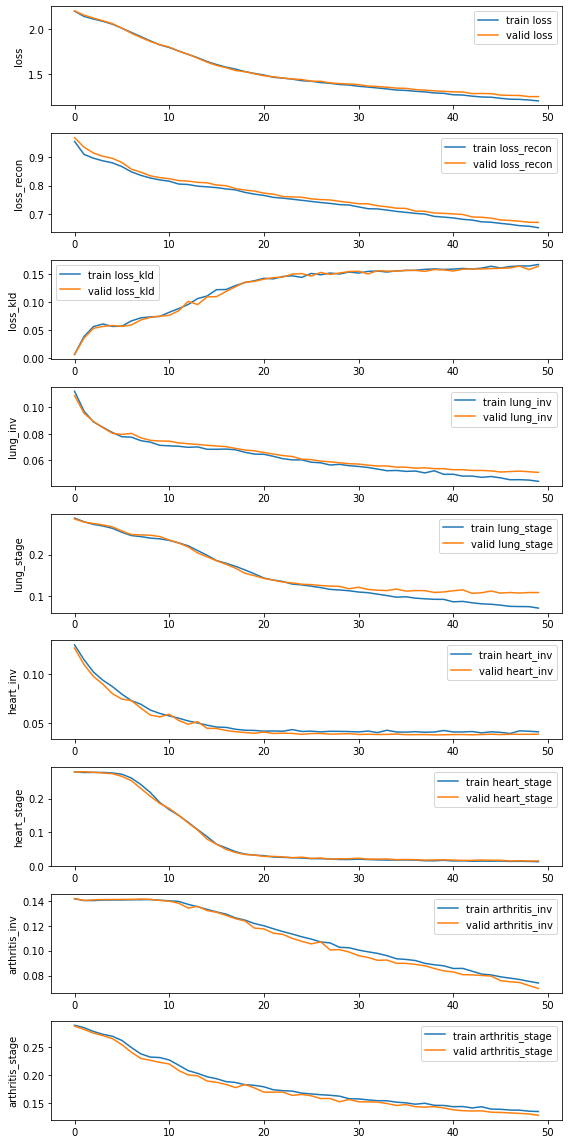

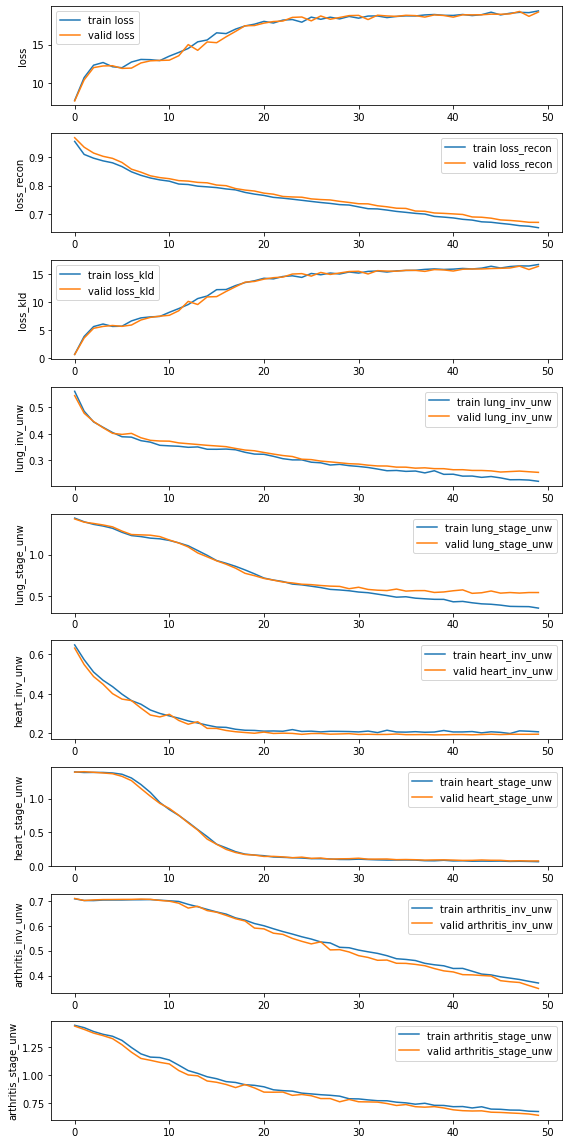

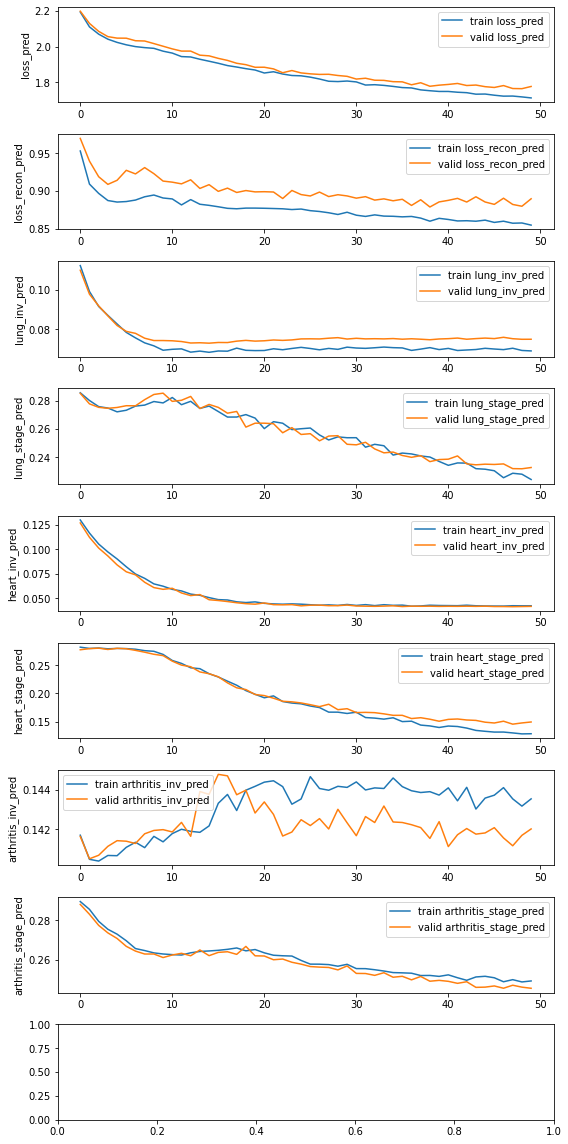

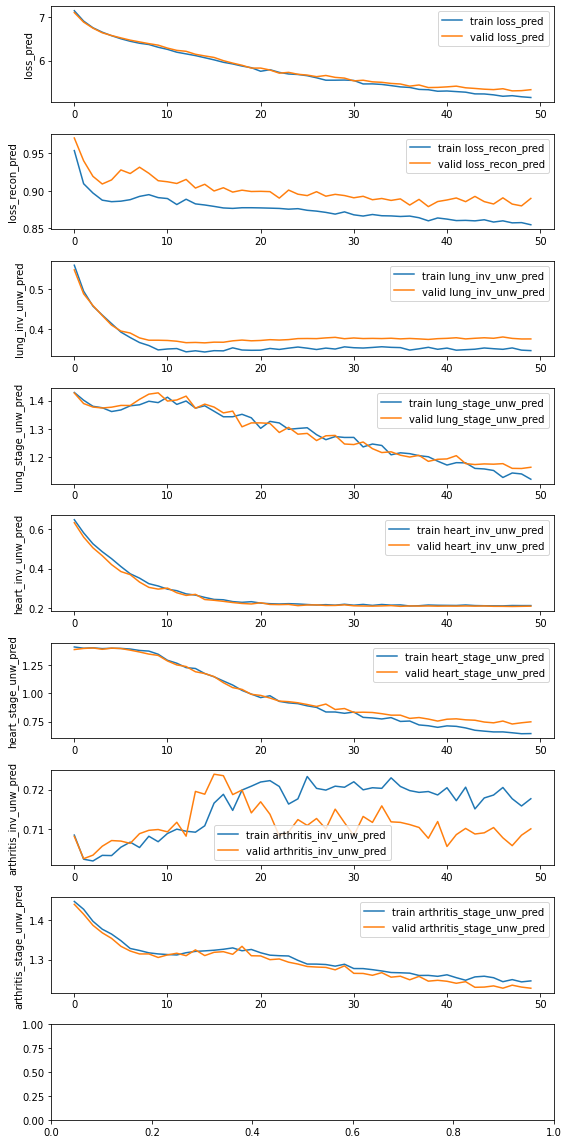

In [6]:
plot_losses(pipeline)